In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv("./data/penguins.csv")
df.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
classes = list(df["species"].unique())
classes
labels = df[["species"]]

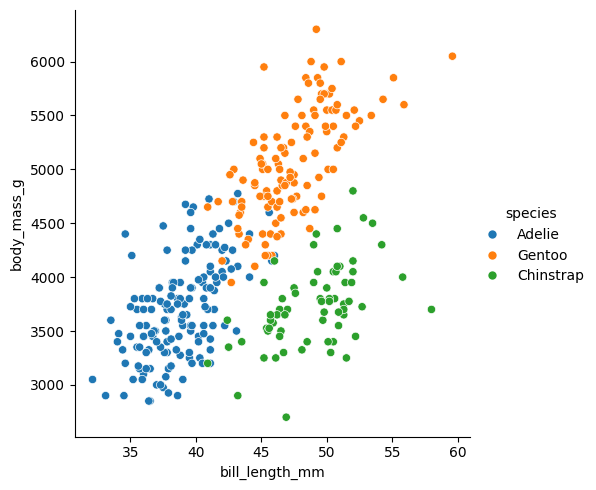

In [4]:
import seaborn as sns
corr_matrix = df[["bill_length_mm",	"bill_depth_mm","flipper_length_mm", "body_mass_g"]].corr()
corr_matrix["flipper_length_mm"].sort_values(ascending=False)
sns.relplot(data=df, x="bill_length_mm", y="body_mass_g", hue="species")

In [5]:
from sklearn.model_selection import train_test_split

df = df.dropna()
y = df["species"]
X = df[["bill_length_mm","bill_depth_mm","flipper_length_mm", "body_mass_g"]]

X.shape, y.shape

((333, 4), (333,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer


all_scalers = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
]

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

model_params = {

    'Logistic_Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l2'],
            'classifier__solver': ['lbfgs']  # Optional, but explicit
        },
        "scalers": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
        ]
    },

    'Random_Forest': {
        'model': RandomForestClassifier(random_state=0),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [None, 10, 20]
        },
        "scalers": all_scalers,
    },

    'Gradient_Boosting': {
        'model': GradientBoostingClassifier(random_state=0),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__learning_rate': [0.01, 0.1]
        },
        "scalers": all_scalers,
    },

    'SVC': {
        'model': SVC(random_state=0),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf']
        },
        "scalers": all_scalers,
    }, 

    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "classifier__n_neighbors":[2, 8, 16, 32],
            "classifier__weights":["uniform", "distance"],
            "classifier__algorithm":["auto", "ball_tree", "kd_tree", "brute"],
        },
        "scalers": all_scalers,
    },

    "KMeans": {
        "model": KMeans(
            n_clusters= len(classes), 
            random_state=0),
        "params": {
            "classifier__algorithm": ["lloyd", "elkan"],
        },
        "scalers": all_scalers,
    },
}


"""
    "ModelName": {
        "model": ModelName(),
        "params": {
            "classifier__arg": [],
        },
        "scalers": all_scalers,
    },

"""
pass 

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from copy import deepcopy
from pprint import pprint

models_best = {}
best_score = 0.0 
best_pipe = None
best_pipe_info = ""
for name, mp in model_params.items():
    for scaler in mp["scalers"]:
        pipeline = Pipeline([ 
            ('scaler', scaler),
            ('classifier', mp['model'])
        ])

        grid = GridSearchCV(pipeline, mp['params'], cv=5, n_jobs=-1, scoring="accuracy")
        grid.fit(X_train, y_train)
        if not name in models_best or grid.best_score_ > models_best[name]["best_score"]:
            models_best[name] = {
                'best_score': grid.best_score_,
                'best_params': grid.best_params_,
                'best_estimator': grid.best_estimator_,
                "best_scaler": scaler,
            }
        if grid.best_score_ > best_score:
            best_pipe = deepcopy(pipeline)
            best_pipe_info = f"{name}:{models_best[name]}"
            best_score = grid.best_score_

best_pipe = best_pipe.fit(X_train, y_train)

sorted_models = dict(sorted(
    models_best.items(),
    key=lambda item: item[1]['best_score'],
    reverse=True
))

for name, result in sorted_models.items():
    print(f"\x1b[92m{name}:\x1b[0m")
    print(f"\tBest Score: \x1b[91m{result['best_score']:.3f}\x1b[0m")
    print(f"\tBest Params: {result['best_params']}")
    print(f"\tBest Scaler: {result['best_scaler']}")
    print("")



SVC:
	Best Score: 0.991
	Best Params: {'classifier__C': 10, 'classifier__kernel': 'linear'}
	Best Scaler: RobustScaler()

Logistic_Regression:
	Best Score: 0.986
	Best Params: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
	Best Scaler: MinMaxScaler()

KNN:
	Best Score: 0.986
	Best Params: {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 16, 'classifier__weights': 'uniform'}
	Best Scaler: StandardScaler()

Random_Forest:
	Best Score: 0.973
	Best Params: {'classifier__max_depth': None, 'classifier__n_estimators': 50}
	Best Scaler: StandardScaler()

Gradient_Boosting:
	Best Score: 0.973
	Best Params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}
	Best Scaler: StandardScaler()

KMeans:
	Best Score: 0.000
	Best Params: {'classifier__algorithm': 'lloyd'}
	Best Scaler: StandardScaler()



In [10]:
print("Winner:")
pprint(best_pipe_info)

Winner:
("SVC:{'best_score': np.float64(0.9910101010101011), 'best_params': "
 "{'classifier__C': 10, 'classifier__kernel': 'linear'}, 'best_estimator': "
 "Pipeline(steps=[('scaler', RobustScaler()),\n"
 "                ('classifier', SVC(C=10, kernel='linear', "
 "random_state=0))]), 'best_scaler': RobustScaler()}")


In [11]:
import joblib
joblib.dump(best_pipe, './data/model_pipe.pkl')

['./data/model_pipe.pkl']

In [12]:
from sklearn.metrics import accuracy_score


loaded_model = joblib.load('./data/model_pipe.pkl')
y_pred = loaded_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")

Accuracy: 0.982


In [13]:
X_test.to_csv("./data/X_test.csv", index=False)